## Baseline model

In [3]:
import torch
from omegaconf import OmegaConf

from einops import rearrange

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, DDIMScheduler

from unipaint.pipelines.pipeline_unipaint import AnimationPipeline
from unipaint.models.unet import UNet3DConditionModel
from unipaint.models.sparse_controlnet import SparseControlNetModel
from unipaint.models.unipaint.brushnet import BrushNetModel

from unipaint.utils.util import load_weights,save_videos_grid
import decord
decord.bridge.set_bridge("torch")
from unipaint.utils.mask import StaticRectangularMaskGenerator

data = "Running4"
path = "models/StableDiffusion/stable-diffusion-v1-5"
brushnet_path = "models/BrushNet/random_mask_brushnet_ckpt"
device = "cuda:4"
dtype = torch.float16

use_motion_module = True
use_adapter = True

motion_module_path = "models/Motion_Module/v3_sd15_mm.ckpt" if use_motion_module else ""
adapter_path = "models/Motion_Module/v3_sd15_adapter.ckpt" if use_adapter else ""

In [4]:
#load base model
tokenizer        = CLIPTokenizer.from_pretrained(path, subfolder="tokenizer", torch_dtype=dtype)
text_encoder     = CLIPTextModel.from_pretrained(path, subfolder="text_encoder").to(device,dtype)
vae              = AutoencoderKL.from_pretrained(path, subfolder="vae").to(device, dtype)

inference_config = OmegaConf.load("configs/inference/inference-v3.yaml")
unet             = UNet3DConditionModel.from_pretrained_2d(path, subfolder="unet", unet_additional_kwargs=OmegaConf.to_container(inference_config.unet_additional_kwargs)).to(device, dtype)

#load controlnet
unet.config.num_attention_heads = 8
unet.config.projection_class_embeddings_input_dim = None
controlnet_config = OmegaConf.load("configs/inference/sparsectrl/latent_condition.yaml")
controlnet = SparseControlNetModel.from_unet(unet, controlnet_additional_kwargs=controlnet_config.get("controlnet_additional_kwargs", {}))
controlnet_state_dict = torch.load("models/Motion_Module/v3_sd15_sparsectrl_rgb.ckpt", map_location="cpu")
controlnet_state_dict = controlnet_state_dict["controlnet"] if "controlnet" in controlnet_state_dict else controlnet_state_dict
controlnet_state_dict = {name: param for name, param in controlnet_state_dict.items() if "pos_encoder.pe" not in name}
controlnet_state_dict.pop("animatediff_config", "")
controlnet.load_state_dict(controlnet_state_dict)
controlnet.to(device, dtype)

#load brushnet
brushnet = BrushNetModel.from_pretrained(brushnet_path, torch_dtype=dtype).to(device)

#build pipeline
pipeline = AnimationPipeline(
            vae=vae, text_encoder=text_encoder, tokenizer=tokenizer, unet=unet,
            controlnet=controlnet, brushnet = brushnet,
            scheduler=DDIMScheduler(beta_start=0.00085,
                                                beta_end=0.012,
                                                beta_schedule="linear",
                                                steps_offset=0,
                                                clip_sample=False)
                                                ).to(device)

loaded 3D unet's pretrained weights from models/StableDiffusion/stable-diffusion-v1-5 ...
### missing keys: 520; 
### unexpected keys: 0;
### Motion Module Parameters: 417.1376 M


In [ ]:
pipeline = load_weights(
    pipeline,
    # motion module
    motion_module_path         = motion_module_path,
    motion_module_lora_configs = [],
    # domain adapter
    adapter_lora_path          = adapter_path,
    adapter_lora_scale         = 1.0,
    # image layers
    dreambooth_model_path      = "",
    lora_model_path            = "",
    lora_alpha                 = 0.8,
).to(device)

load motion module from models/Motion_Module/v3_sd15_mm.ckpt
load domain lora from models/Motion_Module/v3_sd15_adapter.ckpt


# Read Video
Here we read frames of a video and generate a corresponding mask. The data is normalized to [0, 1], in shape (b f) c h w.

In [5]:
video_path = f"outpaint_videos/SB_{data}.mp4"
vr = decord.VideoReader(video_path, width=512, height=512)

video = vr.get_batch(list(range(0,16)))
video = rearrange(video, "f h w c -> c f h w")
frame = torch.clone(torch.unsqueeze(video/255, dim=0)).to(device, brushnet.dtype)
del(vr)
mask_generator = StaticRectangularMaskGenerator(mask_l=[0,0.4],
                                          mask_r=[0,0.4],
                                          mask_t=[0,0.4],
                                          mask_b=[0,0.4])
mask = mask_generator(frame)
frame[mask==1]=0
mask = mask.to(device, brushnet.dtype)
frame = frame*2.-1.
mask = mask*2.-1.

save_videos_grid(((frame+1)/2).cpu(), f"samples/{data}/masked_video.gif")

In [ ]:
prompt = "a man in blue, running"
n_prompt = "worst quality, low quality, letterboxed"
sample = pipeline(
    prompt = prompt,
    negative_prompt     = n_prompt,
    num_inference_steps = 25,
    guidance_scale      = 12.5,
    width               = 512,
    height              = 512,
    video_length        = 16,

    controlnet_images = None,
    controlnet_image_index = [0],
    controlnet_conditioning_scale=0.0,

    init_video = frame[:,:,:],
    mask_video = mask[:,:,:],
    brushnet_conditioning_scale = 1.0,
    control_guidance_start = 0.0,
    control_guidance_end = 1.0,
    ).videos
save_videos_grid(sample, f"samples/{data}/brushnet_mm_{use_motion_module}_adapter_{use_adapter}.gif")

controlnet_images = torch.clone(frame)
num_controlnet_images = controlnet_images.shape[2]
controlnet_images = rearrange(controlnet_images, "b c f h w -> (b f) c h w")
controlnet_images = vae.encode(controlnet_images).latent_dist.sample() * 0.18215
controlnet_images = rearrange(controlnet_images, "(b f) c h w -> b c f h w", f=num_controlnet_images)

sample = pipeline(
    prompt = prompt,
    negative_prompt     = n_prompt,
    num_inference_steps = 25,
    guidance_scale      = 12.5,
    width               = 512,
    height              = 512,
    video_length        = 16,

    controlnet_images = controlnet_images,
    controlnet_image_index = [0],
    controlnet_conditioning_scale=1.0
).videos
save_videos_grid(sample, f"samples/{data}/controlnet_mm_{use_motion_module}_adapter_{use_adapter}.gif")

100%|██████████| 16/16 [00:01<00:00, 13.69it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 95.11 GiB of which 88.25 MiB is free. Process 381632 has 320.00 MiB memory in use. Process 381635 has 320.00 MiB memory in use. Process 381630 has 320.00 MiB memory in use. Process 381628 has 64.61 GiB memory in use. Process 381634 has 320.00 MiB memory in use. Process 381629 has 320.00 MiB memory in use. Process 381633 has 320.00 MiB memory in use. Process 381631 has 320.00 MiB memory in use. Process 3075899 has 28.17 GiB memory in use. Of the allocated memory 27.26 GiB is allocated by PyTorch, and 411.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Possible trainings

1. Trainable params: options
    1. Motion Lora
    2. Temporal layers in Brushnet (How?)
    3. Whole motion module
2. Data
    1. WebVid or similar video datasets
    2. Maybe some video segmentation dataset? These dataset should provide masks and corresponding tags
3. How to train
    - I have no experience of training a large model from scratch


In [6]:
import torch
from unipaint.data.dataset import WebVid10M
import decord
decord.bridge.set_bridge("torch")
dataset = WebVid10M(
        csv_path="data/webvid-10M/data/train/partitions/0000.csv",
        video_folder="/mnt/data/user/fan_xiaoran/data/videos/webvid-10M/videos",
        sample_size=256,
        sample_stride=4, 
        sample_n_frames=16
    )

In [11]:
sample = dataset.__getitem__(42)

In [14]:
pixel_values = sample["pixel_values"]
pixel_values.max()

tensor(1.0000)

'Airplane landing chepstow'

In [ ]:
pixel_values = rearrange(pixel_values, "f c h w -> c f h w")
frame = torch.clone(torch.unsqueeze(pixel_values, dim=0)).to(device)
mask_generator = RectangularMaskGenerator(mask_l=[0,0.4],
                                          mask_r=[0,0.4],
                                          mask_t=[0,0.4],
                                          mask_b=[0,0.4])
mask = mask_generator(frame)
frame[mask==1]=0
mask = mask.to(device)
frame = frame*2.-1.
mask = mask*2.-1.

save_videos_grid(((frame+1)/2).cpu(), f"./test_masked_video.gif")

In [ ]:
timesteps = torch.tensor([212,41,213,2]).unsqueeze(dim=1)
timesteps = torch.cat([timesteps]*16,dim=1).flatten()
timesteps

tensor([212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212,
        212, 212,  41,  41,  41,  41,  41,  41,  41,  41,  41,  41,  41,  41,
         41,  41,  41,  41, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213,
        213, 213, 213, 213, 213, 213,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   2])

In [2]:
import os
import torch
from omegaconf import OmegaConf

from einops import rearrange

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, DDIMScheduler

from unipaint.pipelines.pipeline_unipaint import AnimationPipeline
from unipaint.models.unet import UNet3DConditionModel
from unipaint.models.sparse_controlnet import SparseControlNetModel
from unipaint.models.unipaint.brushnet import BrushNetModel

from unipaint.utils.util import load_weights,save_videos_grid
import decord
decord.bridge.set_bridge("torch")
from unipaint.utils.mask import RectangularMaskGenerator
path = "models/StableDiffusion/stable-diffusion-v1-5"
brushnet_path = "models/BrushNet/random_mask_brushnet_ckpt"
device = "cuda:4"
dtype = torch.float16

use_motion_module = True
use_adapter = True

motion_module_path = "models/Motion_Module/v3_sd15_mm.ckpt" if use_motion_module else ""
adapter_path = "models/Motion_Module/v3_sd15_adapter.ckpt" if use_adapter else ""

#load base model
tokenizer        = CLIPTokenizer.from_pretrained(path, subfolder="tokenizer", torch_dtype=dtype)
text_encoder     = CLIPTextModel.from_pretrained(path, subfolder="text_encoder").to(device,dtype)
vae              = AutoencoderKL.from_pretrained(path, subfolder="vae").to(device, dtype)

inference_config = OmegaConf.load("configs/inference/inference-v3.yaml")
unet             = UNet3DConditionModel.from_pretrained_2d(path, subfolder="unet", unet_additional_kwargs=OmegaConf.to_container(inference_config.unet_additional_kwargs)).to(device, dtype)

#load brushnet
brushnet = BrushNetModel.from_pretrained(brushnet_path, torch_dtype=dtype).to(device)

#build pipeline
pipeline = AnimationPipeline(
            vae=vae, text_encoder=text_encoder, tokenizer=tokenizer, unet=unet,
            brushnet = brushnet,
            scheduler=DDIMScheduler(beta_start=0.00085,
                                                beta_end=0.012,
                                                beta_schedule="linear",
                                                steps_offset=0,
                                                clip_sample=False)
                                                ).to(device)

pipeline = load_weights(
    pipeline,
    # motion module
    motion_module_path         = motion_module_path,
    motion_module_lora_configs = [],
    # domain adapter
    adapter_lora_path          = adapter_path,
    adapter_lora_scale         = 1.0,
    # image layers
    dreambooth_model_path      = "",
    lora_model_path            = "",
    lora_alpha                 = 0.8,
).to(device)

unet_checkpoint_path = "outputs/unipaint_training_mask-2024-09-03T18-40-37/checkpoints/checkpoint.ckpt"
unet_checkpoint_path = torch.load(unet_checkpoint_path, map_location="cpu")
if "global_step" in unet_checkpoint_path: print(f"global_step: {unet_checkpoint_path['global_step']}")
state_dict = unet_checkpoint_path["state_dict"] if "state_dict" in unet_checkpoint_path else unet_checkpoint_path
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace('module.', '')  # Remove 'module.' from each key
    new_state_dict[new_key] = v

m, u = unet.load_state_dict(new_state_dict, strict=False)

/opt/miniconda3/envs/tuna/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loaded 3D unet's pretrained weights from models/StableDiffusion/stable-diffusion-v1-5 ...
### missing keys: 520; 
### unexpected keys: 0;
### Motion Module Parameters: 417.1376 M
load motion module from models/Motion_Module/v3_sd15_mm.ckpt
load domain lora from models/Motion_Module/v3_sd15_adapter.ckpt
global_step: 13000


In [5]:
import numpy as np
name = "chicken"
if name == "eagle":
    video_path = f"outpaint_videos/SB_Eagle.mp4"
    prompt = "a white head bald eagle"
    n_prompt = ""
    data = np.load('SB_Eagle_mask.npz')
if name == "chicken":
    video_path = f"outpaint_videos/SB_Eagle.mp4"
    prompt = "a chicke"
    n_prompt = ""
    data = np.load('SB_Eagle_mask.npz')
if name == "dog":
    video_path = f"outpaint_videos/SB_Dog1.mp4"
    prompt = "a white fluffy dog walking"
    n_prompt = ""
    data = np.load('SB_Dog1_mask.npz')

vr = decord.VideoReader(video_path, width=512, height=512)

video = vr.get_batch(list(range(0,16)))
video = rearrange(video, "f h w c -> c f h w")
frame = torch.clone(torch.unsqueeze(video/255, dim=0)).to(device, brushnet.dtype)
del(vr)

mask = torch.tensor(np.unpackbits(data['mask']).reshape((16, 512, 512)))
mask = torch.cat([mask.unsqueeze(dim=0)]*3,dim=0).unsqueeze(dim=0)
frame[mask==1]=0
mask = mask.to(device, brushnet.dtype)
frame = frame*2.-1.
mask = mask*2.-1.
save_videos_grid(((frame+1)/2).cpu(), f"./test_masked_video_{name}.gif")
samples = []
samples.append(((frame+1)/2).cpu())
for scale in np.arange(0.0, 1.1, 0.1).tolist():
    sample = pipeline(
        prompt = prompt,
        negative_prompt     = n_prompt,
        num_inference_steps = 25,
        guidance_scale      = 12.5,
        width               = 512,
        height              = 512,
        video_length        = 16,

        init_video = frame[:,:,:],
        mask_video = mask[:,:,:],
        brushnet_conditioning_scale = scale,
        control_guidance_start = 0.0,
        control_guidance_end = 1.0,
        ).videos
    samples.append(sample)
samples = torch.concat(samples)
save_videos_grid(samples, f"./sam_test_{name}.gif")

100%|██████████| 16/16 [00:00<00:00, 27.37it/s]


In [4]:
from unipaint.data.ytvos import YTVOSDataset
import torch
img_folder = "./data/YoutubeVOS/train"
ann_file = "./data/YoutubeVOS/meta_expressions/train/meta_expressions.json"
image_set = "train"

dataset = YTVOSDataset(img_folder, ann_file, sample_size=256, return_masks=True, 
                           num_frames=16)                       

/opt/miniconda3/envs/tuna/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 video num:  3471  clip num:  29631




In [5]:
sample = dataset.__getitem__(634)

In [6]:
sample["text"]

'a monkey climbing down from the top of the tree while another is below'

In [9]:
sample["masks"].to(torch.float32).shape

torch.Size([16, 3, 256, 256])

<Axes: >

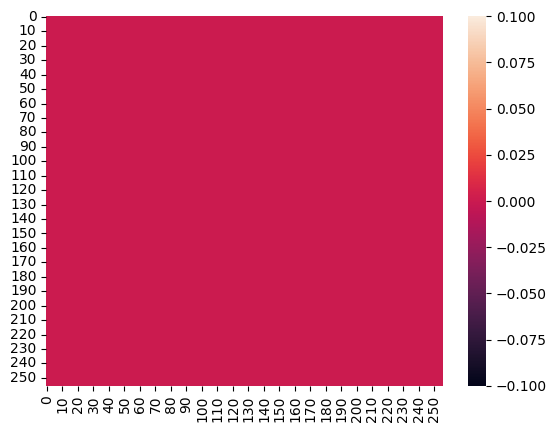

In [6]:
import seaborn as sns
sns.heatmap(sample["masks"].to(torch.float32)[0][0])

In [6]:
sample["masks"].to(torch.float32)==1

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

In [37]:
import torch
import numpy as np

class MovingRectangularMaskGenerator:
    def __init__(self, rect_height_range, rect_width_range) -> None:
        """
        Initialize the MovingRectangularMaskGenerator with random rectangle sizes and movement.

        Args:
        - rect_height_range (tuple): A tuple (min_height, max_height) defining the range for the height of the rectangle.
        - rect_width_range (tuple): A tuple (min_width, max_width) defining the range for the width of the rectangle.
        """
        self.rect_height_range = rect_height_range
        self.rect_width_range = rect_width_range

    def __call__(self, control):
        """
        Generate a moving rectangular mask with random size and random movement.

        Args:
        - control (torch.Tensor): The control tensor to apply the mask to.
                                  Expected shape: (batch, num_frames, channels, height, width)

        Returns:
        - mask (torch.Tensor): The generated moving rectangular mask tensor.
                               Shape: (batch, num_frames, channels, height, width)
        """
        # Control tensor dimensions
        batch_size = control.shape[0]
        num_frames = control.shape[1]
        h = control.shape[-2]
        w = control.shape[-1]

        # Initialize a mask of ones (fully transparent to begin with)
        mask = torch.zeros_like(control)

        # Randomly choose rectangle sizes (height and width) for each sample in the batch
        rect_heights = torch.randint(self.rect_height_range[0], self.rect_height_range[1], (batch_size,))
        rect_widths = torch.randint(self.rect_width_range[0], self.rect_width_range[1], (batch_size,))

        # For each batch element, ensure valid starting and ending positions
        x_start = torch.zeros(batch_size, dtype=torch.long)
        y_start = torch.zeros(batch_size, dtype=torch.long)
        x_end = torch.zeros(batch_size, dtype=torch.long)
        y_end = torch.zeros(batch_size, dtype=torch.long)

        for batch_idx in range(batch_size):
            rect_height = rect_heights[batch_idx]
            rect_width = rect_widths[batch_idx]

            # Ensure the starting point is valid
            x_start[batch_idx] = torch.randint(0, w - rect_width + 1, (1,))
            y_start[batch_idx] = torch.randint(0, h - rect_height + 1, (1,))

            # Ensure the ending point is valid
            x_end[batch_idx] = torch.randint(0, w - rect_width + 1, (1,))
            y_end[batch_idx] = torch.randint(0, h - rect_height + 1, (1,))

        # For each batch element, generate linear interpolation of positions over frames
        for batch_idx in range(batch_size):
            rect_height = rect_heights[batch_idx]
            rect_width = rect_widths[batch_idx]

            # Interpolate the x and y positions for all frames
            x_positions = torch.linspace(x_start[batch_idx], x_end[batch_idx], num_frames).long()
            y_positions = torch.linspace(y_start[batch_idx], y_end[batch_idx], num_frames).long()

            # Apply the moving rectangle to each frame
            for frame_idx in range(num_frames):
                x_st = x_positions[frame_idx]
                y_st = y_positions[frame_idx]
                x_end_frame = min(x_st + rect_width, w)
                y_end_frame = min(y_st + rect_height, h)

                # Apply the mask by zeroing out the pixels inside the rectangle
                mask[batch_idx, frame_idx, :, y_st:y_end_frame, x_st:x_end_frame] = 1.0

        return mask
# Example usage
batch_size = 2
num_frames = 16
height, width = 256, 256

# Simulated control tensor (e.g., batch of videos)
control_tensor = torch.randn((batch_size, num_frames, 3, height, width))

# Instantiate the moving rectangular mask generator with random size and movement
mask_generator = MovingRectangularMaskGenerator(
    rect_height_range=(30, 100),  # Random height between 5 and 20 pixels
    rect_width_range=(30, 100),   # Random width between 5 and 20 pixels
)

# Generate the mask
mask = mask_generator(control_tensor)

In [36]:
from unipaint.utils.util import save_videos_grid
save_videos_grid(mask.permute(0,2,1,3,4).to(torch.float), "./mask.gif")

In [26]:
mask.shape

torch.Size([2, 16, 3, 256, 256])

In [6]:
from unipaint.utils.mask import StaticRectangularMaskGenerator, MovingRectangularMaskGenerator, MarginalMaskGenerator, InterpolationMaskGenerator
import torch
mask_generators = [
    StaticRectangularMaskGenerator(mask_l=[0,0.4],
                                    mask_r=[0,0.4],
                                    mask_t=[0,0.4],
                                    mask_b=[0,0.4]),  # Example generator with fixed sizes
    MovingRectangularMaskGenerator(rect_height_range=(30, 100), rect_width_range=(30, 100)),  # Random size
    MarginalMaskGenerator(mask_l=[0,0.4],
                        mask_r=[0,0.4],
                        mask_t=[0,0.4],
                        mask_b=[0,0.4]),  # Random margin width
    InterpolationMaskGenerator(stride_range=(2, 5))  # Random stride
]
# Example usage
batch_size = 2
num_frames = 16
height, width = 256, 256

# Simulated control tensor (e.g., batch of videos)
control_tensor = torch.randn((batch_size, num_frames, 3, height, width))

for generator in mask_generators:
    mask = generator(control_tensor)
    print(mask.shape)

torch.Size([2, 16, 3, 256, 256])
torch.Size([2, 16, 3, 256, 256])
torch.Size([2, 16, 3, 256, 256])
torch.Size([2, 16, 3, 256, 256])


In [17]:
video_path = f"outpaint_videos/SB_{data}.mp4"
vr = decord.VideoReader(video_path, width=512, height=512)

video = vr.get_batch(list(range(0,16)))
video = rearrange(video, "f h w c -> c f h w")
frame = torch.clone(torch.unsqueeze(video/255, dim=0)).to(device, brushnet.dtype)
del(vr)
mask_generator = MovingRectangularMaskGenerator(rect_height_range=(30, 100), rect_width_range=(30, 100)) # Random margin width
mask = mask_generator(frame)
frame[mask==1]=0
mask = mask.to(device, brushnet.dtype)
frame = frame*2.-1.
mask = mask*2.-1.

save_videos_grid(((frame+1)/2).cpu(), f"samples/{data}/masked_video.gif")

In [16]:
class MovingRectangularMaskGenerator:
    def __init__(self, rect_height_range, rect_width_range) -> None:
        """
        Initialize the MovingRectangularMaskGenerator with random rectangle sizes and movement.

        Args:
        - rect_height_range (tuple): A tuple (min_height, max_height) defining the range for the height of the rectangle.
        - rect_width_range (tuple): A tuple (min_width, max_width) defining the range for the width of the rectangle.
        """
        self.rect_height_range = rect_height_range
        self.rect_width_range = rect_width_range

    def __call__(self, control):
        """
        Generate a moving rectangular mask with random size and random movement.

        Args:
        - control (torch.Tensor): The control tensor to apply the mask to.
                                  Expected shape: (batch, num_frames, channels, height, width)

        Returns:
        - mask (torch.Tensor): The generated moving rectangular mask tensor.
                               Shape: (batch, num_frames, channels, height, width)
        """
        # Control tensor dimensions
        batch_size = control.shape[0]
        num_frames = control.shape[2]
        h = control.shape[-2]
        w = control.shape[-1]

        # Initialize a mask of ones (fully transparent to begin with)
        mask = torch.zeros_like(control)

        # Randomly choose rectangle sizes (height and width) for each sample in the batch
        rect_heights = torch.randint(self.rect_height_range[0], self.rect_height_range[1], (batch_size,))
        rect_widths = torch.randint(self.rect_width_range[0], self.rect_width_range[1], (batch_size,))

        # For each batch element, ensure valid starting and ending positions
        x_start = torch.zeros(batch_size, dtype=torch.long)
        y_start = torch.zeros(batch_size, dtype=torch.long)
        x_end = torch.zeros(batch_size, dtype=torch.long)
        y_end = torch.zeros(batch_size, dtype=torch.long)

        for batch_idx in range(batch_size):
            rect_height = rect_heights[batch_idx]
            rect_width = rect_widths[batch_idx]

            # Ensure the starting point is valid
            x_start[batch_idx] = torch.randint(0, w - rect_width + 1, (1,))
            y_start[batch_idx] = torch.randint(0, h - rect_height + 1, (1,))

            # Ensure the ending point is valid
            x_end[batch_idx] = torch.randint(0, w - rect_width + 1, (1,))
            y_end[batch_idx] = torch.randint(0, h - rect_height + 1, (1,))

        # For each batch element, generate linear interpolation of positions over frames
        for batch_idx in range(batch_size):
            rect_height = rect_heights[batch_idx]
            rect_width = rect_widths[batch_idx]

            # Interpolate the x and y positions for all frames
            x_positions = torch.linspace(x_start[batch_idx], x_end[batch_idx], num_frames).long()
            y_positions = torch.linspace(y_start[batch_idx], y_end[batch_idx], num_frames).long()

            # Apply the moving rectangle to each frame
            for frame_idx in range(num_frames):
                x_st = x_positions[frame_idx]
                y_st = y_positions[frame_idx]
                x_end_frame = min(x_st + rect_width, w)
                y_end_frame = min(y_st + rect_height, h)

                # Apply the mask by zeroing out the pixels inside the rectangle
                mask[batch_idx, :, frame_idx, y_st:y_end_frame, x_st:x_end_frame] = 1.0

        return mask